# Exploration 13. Movie Recommandation
---
# (프로젝트) 영화 추천하기

## [루브릭]
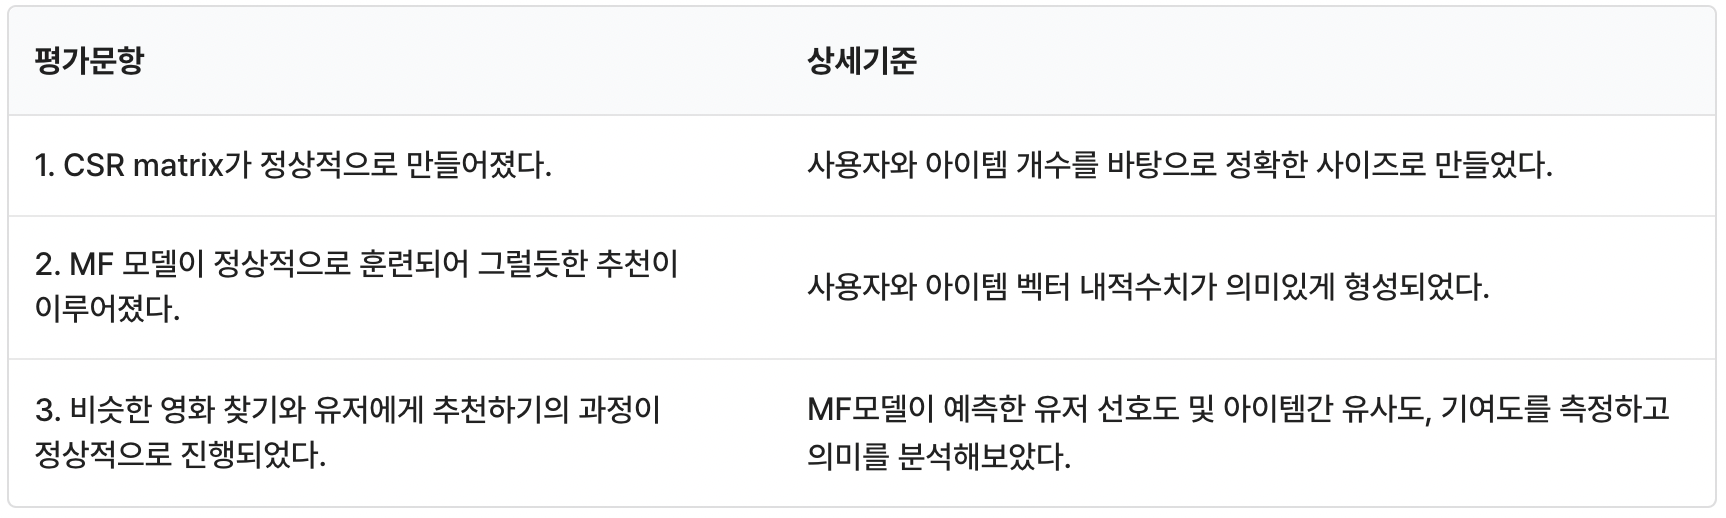

In [1]:
import numpy as np
import scipy
import implicit
import pandas as pd
# pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
# pd.set_option('display.max_rows', None) ## 모든 행을 출력한다.

## STEP 1. 데이터 준비와 전처리

In [2]:
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
original_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   ratings    1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [4]:
ratings.describe()

,user_id,movie_id,ratings,timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [5]:
# 유저별 몇개의 영화를 봤는지에 대한 통계
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: movie_id, dtype: float64

In [6]:
# 좋아하는 영화 기준을 평점 3점으로 잡고 평점 3점 이상만 추출합니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'original_data_size : {original_data_size}, filtered_data_size : {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / original_data_size :.2%}')

original_data_size : 1000209, filtered_data_size : 836478
Ratio of Remaining Data is 83.63%


In [7]:
# ratings 컬럼 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings' : 'counts'}, inplace=True)

In [8]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    836478 non-null  int64
 1   movie_id   836478 non-null  int64
 2   counts     836478 non-null  int64
 3   timestamp  836478 non-null  int64
dtypes: int64(4)
memory usage: 31.9 MB


In [10]:
ratings.describe()

,user_id,movie_id,counts,timestamp
count,836478.000000,836478.000000,836478.000000,8.364780e+05
mean,3033.120626,1849.099114,3.958293,9.721628e+08
std,1729.255651,1091.870094,0.762280,1.206216e+07
min,1.000000,1.000000,3.000000,9.567039e+08
25%,1531.000000,1029.000000,3.000000,9.652795e+08
50%,3080.000000,1747.000000,4.000000,9.728388e+08
75%,4485.000000,2763.000000,5.000000,9.752064e+08
max,6040.000000,3952.000000,5.000000,1.046455e+09


In [11]:
ratings.head(10)

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [12]:
# 영화 제목을 보기 위해 메타 데이터를 읽어 옵니다. 
movie_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding= 'ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [14]:
# 영화를 ratings 데이터에 영화 title을 merge하여 같이 볼 수 있도록 하겠습니다.
ratings = pd.merge(ratings, movies[['movie_id', 'title']], on='movie_id', how='left')
ratings

,user_id,movie_id,counts,timestamp,title
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,978302109,James and the Giant Peach (1996)
2,1,914,3,978301968,My Fair Lady (1964)
3,1,3408,4,978300275,Erin Brockovich (2000)
4,1,2355,5,978824291,"Bug's Life, A (1998)"
...,...,...,...,...,...
836473,6040,1090,3,956715518,Platoon (1986)
836474,6040,1094,5,956704887,"Crying Game, The (1992)"
836475,6040,562,5,956704746,Welcome to the Dollhouse (1995)
836476,6040,1096,4,956715648,Sophie's Choice (1982)


In [15]:
# # 고유한 유저, 영화를 찾아내는 코드
# user_unique = ratings['user_id'].unique()
# moive_unique = ratings['movie_id'].unique()

# # 유저, 영화 indexing 하는 코드 idx는 index의 약자입니다.
# user_to_idx = {v:k for k,v in enumerate(user_unique)}
# movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [16]:
# 인기 많은 영화
movie_count = ratings.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [17]:
# 내가 좋아하시는 영화 5개 추가하기
my_favorite = ['Back to the Future (1985)' , 'Matrix, The (1999)' ,'Shawshank Redemption, The (1994)' ,'Star Wars: Episode IV - A New Hope (1977)' ,'Jurassic Park (1993)']

In [18]:
my_favorite = movies.loc[movies['title'].isin(my_favorite)]

In [19]:
my_favorite

,movie_id,title,genre
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
315,318,"Shawshank Redemption, The (1994)",Drama
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi
1250,1270,Back to the Future (1985),Comedy|Sci-Fi
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller


In [20]:
# '10000'이라는 user_id가 해당 영화 rating에 5점씩 주는 내용으로 데이터를 추가하도록 하겠습니다. 
my_movie = pd.DataFrame({'user_id': [10000]*5, 'title': my_favorite.title.tolist(), 'movie_id' : my_favorite.movie_id.tolist(), 'counts':[5]*5})

if not ratings.isin({'user_id':['10000']})['user_id'].any():  
    ratings = ratings.append(my_movie)                          

ratings.tail(10)

,user_id,movie_id,counts,timestamp,title
836473,6040,1090,3,956715518.0,Platoon (1986)
836474,6040,1094,5,956704887.0,"Crying Game, The (1992)"
836475,6040,562,5,956704746.0,Welcome to the Dollhouse (1995)
836476,6040,1096,4,956715648.0,Sophie's Choice (1982)
836477,6040,1097,4,956715569.0,E.T. the Extra-Terrestrial (1982)
0,10000,260,5,NaN,Star Wars: Episode IV - A New Hope (1977)
1,10000,318,5,NaN,"Shawshank Redemption, The (1994)"
2,10000,480,5,NaN,Jurassic Park (1993)
3,10000,1270,5,NaN,Back to the Future (1985)
4,10000,2571,5,NaN,"Matrix, The (1999)"


In [21]:
# index reset 수행
ratings.reset_index(drop=True)

,user_id,movie_id,counts,timestamp,title
0,1,1193,5,978300760.0,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,978302109.0,James and the Giant Peach (1996)
2,1,914,3,978301968.0,My Fair Lady (1964)
3,1,3408,4,978300275.0,Erin Brockovich (2000)
4,1,2355,5,978824291.0,"Bug's Life, A (1998)"
...,...,...,...,...,...
836478,10000,260,5,NaN,Star Wars: Episode IV - A New Hope (1977)
836479,10000,318,5,NaN,"Shawshank Redemption, The (1994)"
836480,10000,480,5,NaN,Jurassic Park (1993)
836481,10000,1270,5,NaN,Back to the Future (1985)


In [22]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836483 entries, 0 to 4
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    836483 non-null  int64  
 1   movie_id   836483 non-null  int64  
 2   counts     836483 non-null  int64  
 3   timestamp  836478 non-null  float64
 4   title      836483 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 38.3+ MB


## STEP 2. Matrix Factorization 수행

In [23]:
from scipy.sparse import csr_matrix

In [24]:
# 유니크한 사용자와 영화 개수
num_user = ratings['user_id'].nunique()
num_movie = ratings['title'].nunique()

In [25]:
num_user, num_movie

(6040, 3628)

In [26]:
csr_data = csr_matrix((ratings['counts'], (ratings.user_id, ratings.movie_id))) # shape=(num_user, num_movie)
csr_data

<10001x3953 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [27]:
from implicit.als import AlternatingLeastSquares
# implicit 라이브러리에서 권장하고 있는 부분입니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [28]:
# Implicit AlternatingLeastSquares 모델 선언
als_model = AlternatingLeastSquares(factors = 100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [29]:
# AlternatinLeastSquares 파라미터 참고
# factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
# regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
# use_gpu : GPU를 사용할 것인지
# iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

In [30]:
csr_data_trans = csr_data.T
csr_data_trans

<3953x10001 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [31]:
als_model.fit(csr_data_trans)

  0%|          | 0/15 [00:00<?, ?it/s]

In [32]:
# 매트릭스와 유사한 영화 리스트 보기

In [33]:
user_10000, matrix_id = als_model.user_factors[10000], als_model.item_factors[2571]

In [34]:
user_10000

array([ 9.39136371e-02,  5.13154566e-02, -3.50700736e-01,  1.03337713e-01,
       -1.21405929e-01, -3.15128684e-01,  8.75146210e-01, -3.25913243e-02,
        4.66246307e-01,  5.85367799e-01, -1.27890420e+00, -7.49207258e-01,
       -1.10771559e-01,  1.24663770e-01,  4.48791504e-01,  8.63004506e-01,
       -2.64914334e-01,  1.88130274e-01,  1.28888583e+00, -4.60625499e-01,
       -5.00800192e-01, -3.42989296e-01, -4.92853485e-02, -4.37741190e-01,
       -2.84987241e-01,  7.60838911e-02,  2.56969690e-01,  3.10796678e-01,
        1.01526573e-01, -3.92748892e-01, -5.38034625e-02, -3.34112555e-01,
        5.34922421e-01,  3.64076287e-01, -6.04437590e-01, -4.39967632e-01,
       -7.26622820e-01, -3.41466337e-01,  2.40391165e-01,  1.14295974e-01,
       -9.18902636e-01,  1.37802708e+00, -3.21352780e-01,  3.10717285e-01,
        3.53290707e-01,  6.31487191e-01, -3.81571800e-01, -6.80873394e-01,
       -3.74815345e-01,  1.26256049e-01, -1.15311134e+00,  3.13996673e-01,
       -1.46196568e+00, -

In [35]:
np.dot(user_10000, matrix_id)

0.603305

In [36]:
user_10000, platoon_id = als_model.user_factors[10000], als_model.item_factors[1090]

In [37]:
np.dot(user_10000, platoon_id)

-0.12938517

In [38]:
similar_movies_to_matrix = als_model.similar_items(2571, N=15)

In [39]:
similar_movies_to_matrix

[(2571, 1.0000001),
 (589, 0.77296966),
 (2916, 0.69575864),
 (457, 0.5962688),
 (1240, 0.57272017),
 (480, 0.5398716),
 (1573, 0.5215742),
 (1580, 0.5129609),
 (1527, 0.50973),
 (32, 0.45674717),
 (260, 0.43445128),
 (1610, 0.42161977),
 (377, 0.38592136),
 (1196, 0.38485187),
 (1214, 0.37087917)]

In [40]:
for i in range(len(similar_movies_to_matrix)):
    print(similar_movies_to_matrix[i][0])

2571
589
2916
457
1240
480
1573
1580
1527
32
260
1610
377
1196
1214


In [41]:
movie_name = []

for i in range(len(similar_movies_to_matrix)):
    fav_movie_id = similar_movies_to_matrix[i][0]
    print(movies[movies['movie_id']==fav_movie_id].title.tolist())

['Matrix, The (1999)']
['Terminator 2: Judgment Day (1991)']
['Total Recall (1990)']
['Fugitive, The (1993)']
['Terminator, The (1984)']
['Jurassic Park (1993)']
['Face/Off (1997)']
['Men in Black (1997)']
['Fifth Element, The (1997)']
['Twelve Monkeys (1995)']
['Star Wars: Episode IV - A New Hope (1977)']
['Hunt for Red October, The (1990)']
['Speed (1994)']
['Star Wars: Episode V - The Empire Strikes Back (1980)']
['Alien (1979)']


In [42]:
movies[movies['title'].str.lower().str.contains('face')]

,movie_id,title,genre
154,156,Blue in the Face (1995),Comedy
487,491,"Man Without a Face, The (1993)",Drama
693,702,Faces (1968),Drama
830,841,Eyes Without a Face (1959),Horror
854,865,Small Faces (1995),Drama
889,901,Funny Face (1957),Comedy|Musical
1332,1353,"Mirror Has Two Faces, The (1996)",Comedy|Romance
1533,1573,Face/Off (1997),Action|Sci-Fi|Thriller
2392,2461,Leatherface: Texas Chainsaw Massacre III (1990),Horror
2969,3038,"Face in the Crowd, A (1957)",Drama


In [43]:
def get_similar_movies(movie_id):
    similar_movies = als_model.similar_items(movie_id, N=15)
    movie_name = []

    for i in range(len(similar_movies)):
        fav_movie_id = similar_movies[i][0]
        movie_name.extend(movies[movies['movie_id']==fav_movie_id].title.tolist())
    
    return movie_name

In [44]:
print(get_similar_movies(2571))

['Matrix, The (1999)', 'Terminator 2: Judgment Day (1991)', 'Total Recall (1990)', 'Fugitive, The (1993)', 'Terminator, The (1984)', 'Jurassic Park (1993)', 'Face/Off (1997)', 'Men in Black (1997)', 'Fifth Element, The (1997)', 'Twelve Monkeys (1995)', 'Star Wars: Episode IV - A New Hope (1977)', 'Hunt for Red October, The (1990)', 'Speed (1994)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Alien (1979)']


In [45]:
# 내가 좋아하는 영화와 유사한 영화 추천하기

In [46]:
user_id = 10000
# recommend에서는 user*item CSR Matrix를 받습니다.
moive_recommended = als_model.recommend(user_id, csr_data, N=20, filter_already_liked_items=True)
moive_recommended

[(589, 0.59622437),
 (1196, 0.5279254),
 (1580, 0.4807351),
 (1210, 0.4475029),
 (593, 0.43350524),
 (1198, 0.43030548),
 (2028, 0.40803882),
 (110, 0.38403052),
 (1193, 0.3599955),
 (1240, 0.3532231),
 (527, 0.32580653),
 (1097, 0.32512748),
 (1197, 0.3112886),
 (2916, 0.3079524),
 (1704, 0.28917897),
 (457, 0.28240597),
 (2858, 0.27501342),
 (608, 0.25607336),
 (2762, 0.23923136),
 (296, 0.2305567)]

In [47]:
def get_movie_recommended(user_id):
    moive_recommended = als_model.recommend(user_id, csr_data, N=20, filter_already_liked_items=True)
    movie_name = []

    for i in range(len(moive_recommended)):
        recommend_movie_id = moive_recommended[i][0]
        movie_name.extend(movies[movies['movie_id']==recommend_movie_id].title.tolist())
    
    return movie_name

In [48]:
get_movie_recommended(10000)

['Terminator 2: Judgment Day (1991)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Men in Black (1997)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Silence of the Lambs, The (1991)',
 'Raiders of the Lost Ark (1981)',
 'Saving Private Ryan (1998)',
 'Braveheart (1995)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Terminator, The (1984)',
 "Schindler's List (1993)",
 'E.T. the Extra-Terrestrial (1982)',
 'Princess Bride, The (1987)',
 'Total Recall (1990)',
 'Good Will Hunting (1997)',
 'Fugitive, The (1993)',
 'American Beauty (1999)',
 'Fargo (1996)',
 'Sixth Sense, The (1999)',
 'Pulp Fiction (1994)']

## 회고  
- 추천 영화 결과를 보니, 대체로 신규 id로 추가한 영화와 유사한 영화 리스트가 출력되었습니다. 

[참고]  
- ALS 이해 : https://yeomko.tistory.com/4